In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [187]:
class LinearRegression:
    def __init__(self, X, y, learning_rate, tolerance, max_iterations, lambda_, sgd_iterations, batch_size, gd=False, regularization=False, sgd=False):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.lambda_ = lambda_  # regularization parameter
        self.sgd_iterations = sgd_iterations
        self.batch_size = batch_size
        self.gd = gd
        self.regularization = regularization
        self.sgd = sgd
        self.iterations_count = []
        self.error_seq = []
        self.X_test = None
        self.y_test = None

    # Step_1: Split data into training and testing
    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, shuffle=True)
        return X_train, X_test, y_train, y_test

    # Step_2: Adding one new column at beginning for intercept
    def add_bias(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    # Step_3: Normalizing the training data and then adding column at beginning for intercept
    def normalize_train(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_norm = (X - mean) / std
        X_norm = self.add_bias(X_norm)
        return mean, std, X_norm

    def normalize_test(self, X, mean, std):
        X_norm = (X - mean) / std
        X_norm = self.add_bias(X_norm)
        return X_norm

    # Step_4: Closed Form solution/Normal Equation (Analytical Approach)
    def normal_equation(self, X, y):
        self.w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    # Regularization (Ridge) with closed form solution
    def ridge_regression_normal(self, X, y, lambda_):
        m = X.shape[1]  # Number of features including intercept
        I = np.identity(m)  # Identity matrix
        I[0, 0] = 0  # Do not regularize the bias term
        self.w = np.linalg.inv(X.T.dot(X) + lambda_ * I).dot(X.T).dot(y)

    def predict(self, X):
        return X.dot(self.w)

    # Sum of Squared Errors
    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()

    # Root Mean Squared Error
    def rmse(self, X, y):
        sse = self.sse(X, y)
        return np.sqrt(sse / X.shape[0])

    # Cost function (RMSE)
    def cost_function_rmse(self, X, y):
        rmse = self.rmse(X, y)
        return rmse / 2

    # Gradient of cost function
    def cost_derivative(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y).dot(X)

    def reg_cost_derivative(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y).dot(X) / X.shape[0]

    # Gradient Descent
    def gradient_descent(self, X, y):
        self.errors = []  # list to keep track of errors
        prev_error = float(np.inf)  # variable that keeps track of previous error

        # Initialize weights with size including intercept term
        self.w = np.zeros(X.shape[1])

        for i in tqdm(range(self.max_iterations)):
            grad = self.cost_derivative(X, y)
            self.w = self.w - self.learning_rate * grad
            current_error = self.cost_function_rmse(X, y)
            self.errors.append(current_error)
            if abs(current_error - prev_error) < self.tolerance:
                print("The model stopped learning")
                break
            prev_error = current_error

        self.plot_rmse(self.errors)

    # Regularization using norm 2 (Ridge Regression)
    def reg_gradient_descent(self, X, y):
        self.errors = []  # list to keep track of errors
        prev_error = float(np.inf)  # variable that keeps track of previous error

        # Initialize weights with size including intercept term
        self.w = np.zeros(X.shape[1])

        for t in tqdm(range(self.max_iterations)):
            grad = self.cost_derivative(X, y) + lambda_ * self.w
            self.w = self.w - self.learning_rate * grad
            current_error = self.cost_function_rmse(X, y)
            self.errors.append(current_error)
            if abs(current_error - prev_error) < self.tolerance:
                print("The model stopped learning")
                break
            prev_error = current_error

        self.plot_rmse(self.errors)

    # Stochastic Gradient Descent
    def sgradient_descent(self, X, y):
        self.errors = []  # list to keep track of errors
        prev_error = float(np.inf)  # variable that keeps track of previous error

        # Initialize weights with size including intercept term
        self.w = np.zeros(X.shape[1])

        for t in tqdm(range(self.sgd_iterations)):
            batch_indices = np.random.randint(0, X.shape[0], self.batch_size)
            self.w = self.w - self.learning_rate * self.cost_derivative(X[batch_indices], y[batch_indices])
            current_error = self.cost_function_rmse(X, y)
            self.errors.append(current_error)
            if abs(current_error - prev_error) < self.tolerance:
                print("The model stopped learning")
                break
            prev_error = current_error

        self.plot_rmse(self.errors)


    # Plot RMSE
    def plot_rmse(self, error_sequence):
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s, label='RMSE')

        ax.set(xlabel='iterations', ylabel='RMSE', title='Error Trend')
        ax.grid()
        ax.legend()

        plt.show()

    # Step_5: One main function connecting everything together
    def fit(self):
        X_train, self.X_test, y_train, self.y_test = self.split_data()
        mean, std, X_train = self.normalize_train(X_train)
        self.X_test = self.normalize_test(self.X_test, mean, std)

        if not self.gd and not self.sgd:
            print("Solving using Normal Equation...")
            if self.lambda_ > 0:
                print("With Regularization")
                self.ridge_regression_normal(X_train, y_train, self.lambda_)
            else:
                print("Without Regularization")
                self.normal_equation(X_train, y_train)
        elif self.gd:
            print("Solving using Gradient Descent...")
            if self.lambda_ > 0:
                print("With Regularization")
                self.reg_gradient_descent(X_train, y_train)
            else:
                print("Without Regularization")
                self.gradient_descent(X_train, y_train)
        elif self.sgd:
            print("Solving using Stochastic Gradient Descent...")
            self.sgradient_descent(X_train, y_train)

        print("Final weights:", self.w)




In [188]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:
# Set working directory
%cd /content/drive/MyDrive/Stats_for_engineers/Lab_1/

/content/drive/MyDrive/Stats_for_engineers/Lab_1


## Housing Dataset

In [212]:
df_housing = pd.read_csv('housing.csv')


In [213]:
df_housing.head()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [191]:
X_housing = df_housing.iloc[:, :-1].values
y_housing = df_housing.iloc[:, -1].values

In [193]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_ = 0,
                       sgd_iterations=100, batch_size=1, gd=False, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
Without Regularization
Final weights: [22.40368272 -0.92929342  0.83186785 -0.12135026  0.98614294 -2.05772926
  2.562468    0.04400682 -3.07788622  2.5233214  -1.77063346 -2.01180771
  0.90894824 -3.96916619]


In [194]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, batch_size=1, gd=False, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
With Regularization
Final weights: [22.39121813 -0.54056773  0.9535065   0.10139214  1.0745541  -1.95659493
  3.07615696 -0.15423011 -3.07985435  2.48749376 -2.00139746 -1.86528751
  1.25363093 -3.37541742]


Solving using Gradient Descent...
Without Regularization


  0%|          | 26/50000 [00:00<00:02, 19380.11it/s]

The model stopped learning


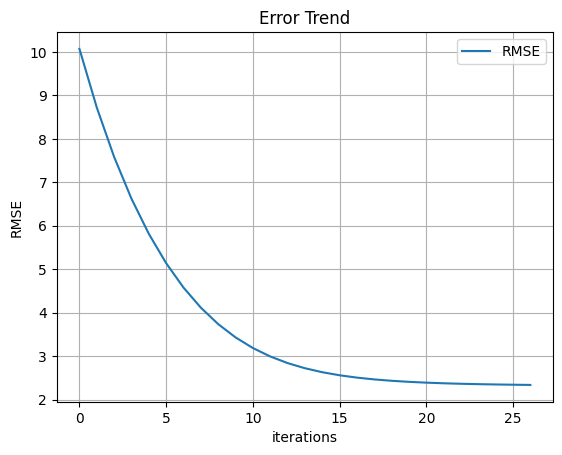

Final weights: [21.89060943 -0.24280928  0.82677197 -0.49290277  0.8481719  -0.78895132
  3.07834917 -0.54554725 -2.01715435  0.53579542 -0.59577138 -1.86371237
  0.78861434 -2.82571728]


In [195]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, batch_size=1, gd=True, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Gradient Descent...
With Regularization


  0%|          | 26/50000 [00:00<00:02, 20614.73it/s]

The model stopped learning


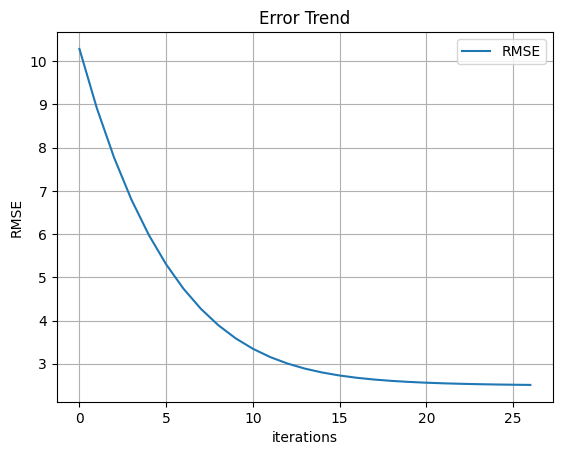

Final weights: [22.16835301 -0.74992792  0.44551419 -0.58942728  0.89086738 -0.55344579
  3.0079025  -0.20446941 -2.0327125   0.94378144 -0.34908788 -1.93389673
  1.29496526 -3.75852016]


In [196]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, batch_size=1, gd=True, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Stochastic Gradient Descent...


 81%|████████  | 81/100 [00:00<00:00, 7460.88it/s]

The model stopped learning


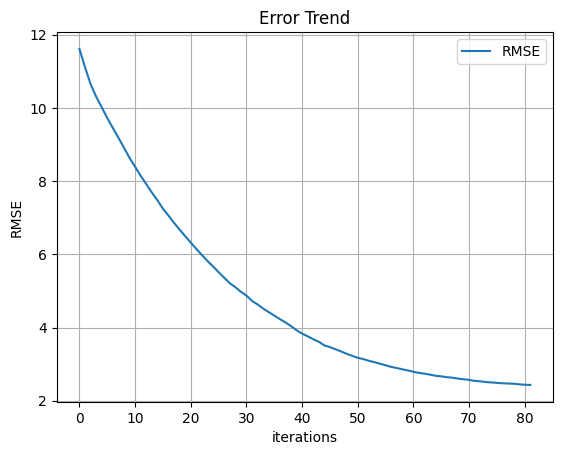

Final weights: [20.72376248 -0.54735904  0.19379379 -0.6024718   1.26125089 -0.30847843
  3.27185459 -0.37068047 -1.45321575  0.27853826 -0.45054418 -1.55006867
  0.87813892 -2.84381367]


In [197]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, batch_size=80, gd=False, regularization=False, sgd=True)
clf.fit()

**Smaller batch sizes in stochastic gradient descent (SGD) lead to faster convergence and lower RMSE values as they update the model more frequently with diverse data points, enabling quicker adjustments towards the optimal solution. Random shuffling ensures effectiveness by preventing the model from being trapped in local minima.**

## Yacht DataSet

In [214]:
df_yacht = pd.read_csv('yachtData.csv')


In [215]:
df_yacht.head()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82


In [199]:
X_yacht = df_yacht.iloc[:, :-1].values
y_yacht = df_yacht.iloc[:, -1].values

In [200]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_ = 0,
                       sgd_iterations=100, batch_size=1, gd=False, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
Without Regularization
Final weights: [11.15014019  0.19376648  0.02608892  2.69860566 -1.94185293 -2.17673082
 13.09005122]


In [201]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, batch_size=1, gd=False, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
With Regularization
Final weights: [ 9.57345794  0.14123739  0.57331093  4.90709547 -3.70592369 -5.39685851
 10.95578121]


Solving using Gradient Descent...
Without Regularization


  0%|          | 17/50000 [00:00<00:02, 22192.08it/s]

The model stopped learning


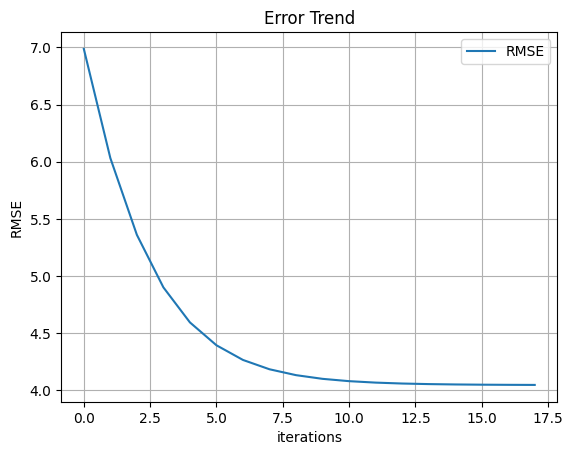

Final weights: [ 9.24342299  0.17177309  0.17144665 -0.21167465 -0.2091275   0.17292346
 10.90691569]


In [202]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, batch_size=1, gd=True, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Gradient Descent...
With Regularization


  0%|          | 17/50000 [00:00<00:02, 20000.89it/s]

The model stopped learning


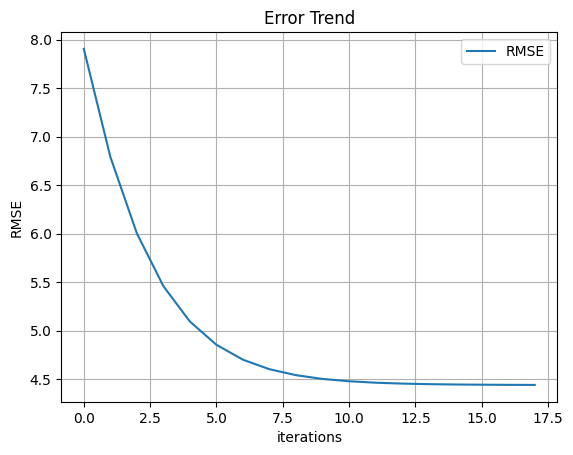

Final weights: [10.92985018  0.67085509 -0.20976841 -0.3082234  -0.30952194 -0.24093272
 12.22402716]


In [203]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, batch_size=1, gd=True, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Stochastic Gradient Descent...


 19%|█▉        | 19/100 [00:00<00:00, 6088.92it/s]

The model stopped learning


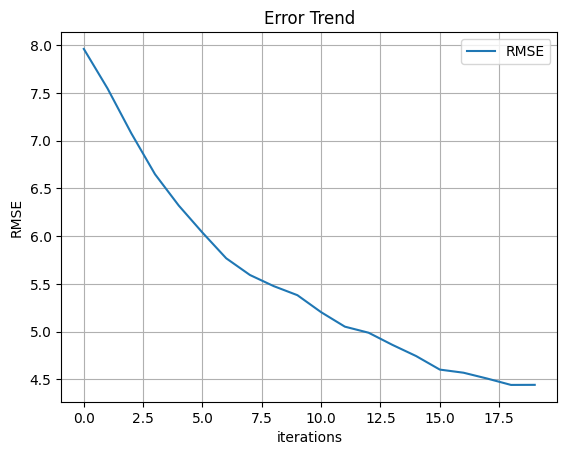

Final weights: [ 7.8081351  -0.10362581  0.45930714  0.55072375  0.2002812   0.30611458
  9.27290345]


In [204]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, batch_size=80, gd=False, regularization=False, sgd=True)
clf.fit()

## Concrete Dataset

In [216]:
df_concrete = pd.read_csv('concreteData.csv')


In [217]:
df_concrete.head()

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


In [206]:

X_concrete = df_concrete.iloc[:, :-1].values
y_concrete = df_concrete.iloc[:, -1].values

In [207]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_ = 0,
                       sgd_iterations=100, batch_size=1, gd=False, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
Without Regularization
Final weights: [35.55354167 12.925824    9.18415887  5.99894448 -2.68388892  1.62553944
  1.60027474  2.09182639  7.37372415]


In [208]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, batch_size=1, gd=False, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
With Regularization
Final weights: [35.87205556 11.79200617  8.14214366  4.85724666 -3.8923545   1.62621356
  0.56893656  1.12634838  7.14618555]


Solving using Gradient Descent...
Without Regularization


  0%|          | 32/50000 [00:00<00:07, 6941.70it/s]

The model stopped learning


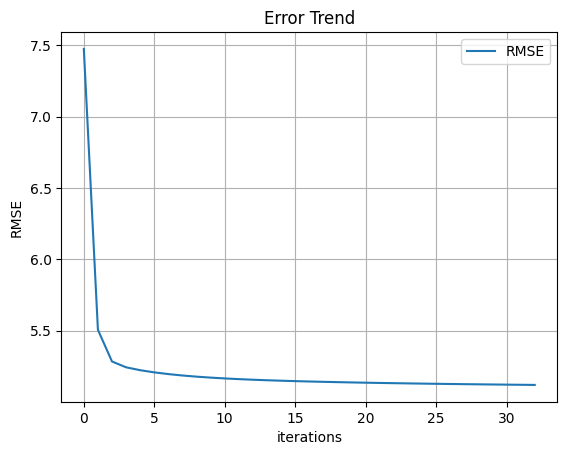

Final weights: [35.69229167  9.35007048  6.22292471  3.07328749 -5.13477124  1.72077351
 -0.39220869 -1.00317777  7.41218238]


In [209]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, batch_size=1, gd=True, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Gradient Descent...
With Regularization


  0%|          | 32/50000 [00:00<00:04, 10282.52it/s]

The model stopped learning


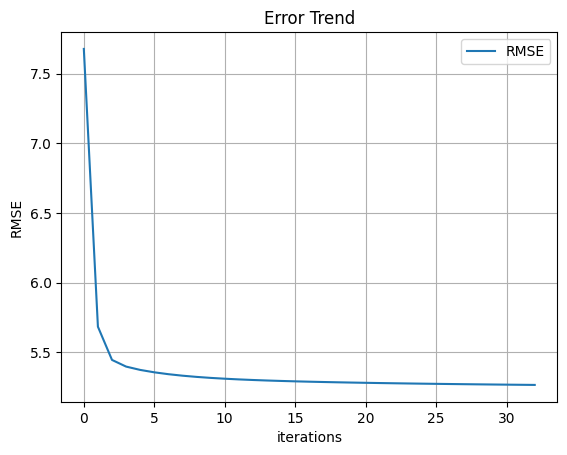

Final weights: [36.49021321  9.89966578  6.18658533  3.06762574 -5.56313591  1.50705593
 -0.8431764  -1.14951491  6.64190305]


In [210]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, batch_size=1, gd=True, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Stochastic Gradient Descent...


 49%|████▉     | 49/100 [00:00<00:00, 7400.03it/s]

The model stopped learning


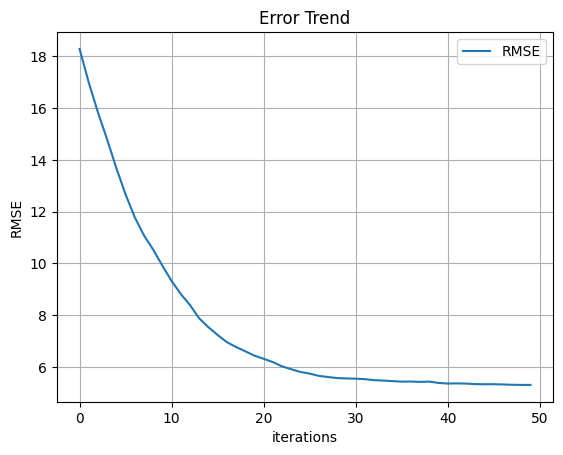

Final weights: [35.47750597  7.03422431  3.65009387 -0.07356063 -5.05036682  3.89262097
 -1.69794777 -2.59400708  6.16191903]


In [211]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, batch_size=80, gd=False, regularization=False, sgd=True)
clf.fit()

## Observations:

## Effects on Learning:

### Learning Rate:
- **Effect on Convergence Speed:** A higher learning rate accelerates convergence, making the model reach an acceptable solution faster. However, if the learning rate is too high, the model might oscillate around the optimal solution or even diverge.

### Regularization Parameter:
- **Control Overfitting:** Increasing the regularization parameter encourages the model to favor simpler solutions, which helps prevent overfitting on the training data. However, setting it too high may excessively constrain the model, leading to underfitting and poor performance on both training and test data.
- **Balance Between Bias and Variance:** Finding the right balance in the regularization parameter is crucial. A moderate regularization parameter value typically achieves the best tradeoff between bias and variance, resulting in a model that generalizes well to unseen data.

## Conclusion:
Optimizing the learning rate and regularization parameters involves finding the right balance between convergence speed, stability, and model complexity. Experimentation and validation on a separate validation dataset are essential to determine the optimal values for these parameters, ensuring that the trained model generalizes well to unseen data while avoiding underfitting and overfitting issues.

